# Fitting SFG Curves with Multiple Resonant Peaks
Using the iminuit package, select a window of SFG spectra and perform a non-linear fit of nonresonant and a variable number ($N^{res}$) of resonant peaks accoring to the equation
$$ \mathrm{SFG}(\omega) = \left| A^{nonres}e^{i\phi} + \sum_{j=0}^{N^{res}}\frac{A^{res}_j}{\omega - \omega^{res}_j+i\Gamma_j}\right|^2 $$
where the parameters that we want to determine are the nonresonant amplitue ($A^{nonres}$) and phase ($\phi$), as well as the amplitude, position, and width of each resonant peak ($A^{res}_j$, $\omega^{res}_j$, and $\Gamma_j$, respectively).

Developers : Oliviero Andreussi, Lindsey Jenkins, XXX, XXX, Jenee Cyran


## Mount the Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import External Modules

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
!pip install iminuit
from iminuit import Minuit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 427.4/427.4 kB 10.1 MB/s eta 0:00:00


## Define Basic Functions for the Fitting

In [3]:
# Basic functions for the fitting of nonresonant and resonant peaks
def chi_non_resonant(nr: float, phase: float) -> np.complex128 :
  """
  Given the non-resonant parameters return a single complex-valued number
  for the non-resonant process
  """
  ChiNR = nr * np.exp(1j * phase)
  return ChiNR

def chi_resonant(wavenumbers: np.ndarray[np.float64], amplitude: float, pos: float, width: float) -> np.ndarray[np.complex128]:
  """
  Given a range of wavenumbers and the parameters of a resonant peak return
  the complex values of the peak for each wavenumber
  """
  A = amplitude
  delta = wavenumbers - pos
  gamma = width / 2
  ChiR_i = -(A * gamma / (delta**2 + gamma**2))
  ChiR_r = A * delta / (delta**2 + gamma**2)
  ChiR = ChiR_r + (1j * ChiR_i)
  return ChiR

In [10]:
from typing import Callable
def curry(data: np.ndarray, func: Callable) -> Callable :

  def curriedfunc(*args):
    return func(data, *args)

  return curriedfunc

def costfunction_of_sfg(sfg: np.ndarray[np.float64], *args) -> np.float64 :
  return np.sum((sfg - calcamplitude(*args))**2)

def calcamplitude_of_wavenumbers(wavenumbers: np.ndarray[np.float64], *args) -> np.ndarray[np.float64] :
  Chi = np.zeros(wavenumbers.shape,dtype=np.complex128)
  Chi = Chi + chi_non_resonant(args[0], args[1])
  nres = (len(args)-2)//3
  for i in range(nres):
    iarg = 3*i+2
    ChiR = chi_resonant(wavenumbers, args[iarg], args[iarg+1], args[iarg+2])
    Chi = Chi + ChiR
  return np.square(Chi.real) + np.square(Chi.imag)

def calcimaginary_of_wavenumbers(wavenumbers: np.ndarray[np.float64], *args) -> np.ndarray[np.float64]:
  Chi = np.zeros(wavenumbers.shape,dtype=np.complex128)
  Chi = Chi + chi_non_resonant(args[0], args[1])
  nres = (len(args)-2)//3
  for i in range(nres):
    iarg = 3*i+2
    ChiR = chi_resonant(wavenumbers, args[iarg], args[iarg+1], args[iarg+2])
    Chi = Chi + ChiR
  return Chi.imag

In [13]:
# Let's assume that we will always have a nonresonant dictionary plus a list of resonant dictionaries
# NOTE: this function allows to have different names for the resonant peak dictionaries
# and we can select which ones we add when we call the function
def combine_params( nonresonant_params: dict, resonant_list: list[dict] ) -> dict :
  # start with the nonresonant parameters
  parameters = { 'nr_'+k: v for k,v in nonresonant_params.items() }
  # add the resonant parameters naming them r1_ , r2_ , r3_, ...
  nres = len(resonant_list)
  for i, resonant_params in enumerate(resonant_list):
    new = {'r'+str(i)+'_'+k:v for k,v in resonant_params.items() }
    parameters = {**parameters, **new}
  return parameters

## Load Data

In [4]:
# Data should be cleaned using MATLAB data cleaner first
path = '/content/drive/MyDrive/SFG/'
#x = pd.read_csv(path+'xaxis.csv',names=['Wavenumbers'],skiprows=1) #skips header
#y = pd.read_csv(path+'yaxis.csv',names=['SFG'],skiprows=1) #change name to what sample it is

# Uncomment to make sure that the size of the arrays are the same size
# x.shape
# y.shape
# Makes the arrays into a data structure
#data = pd.concat([x,y],axis=1)
data = pd.read_csv(path+'cleanIce8.csv',names=['Wavenumbers','SFG'],skiprows=1)

## Plot of data

<Axes: xlabel='Wavenumbers'>

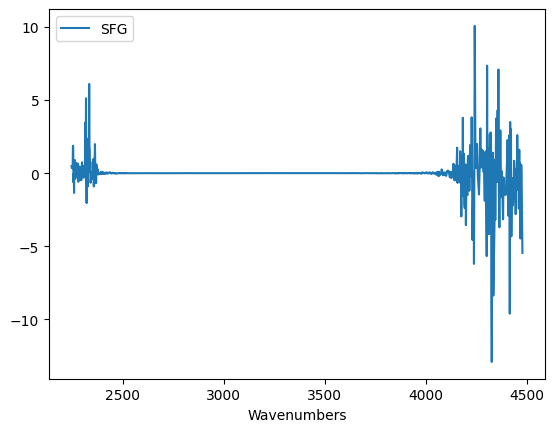

In [5]:
data.plot('Wavenumbers', 'SFG')

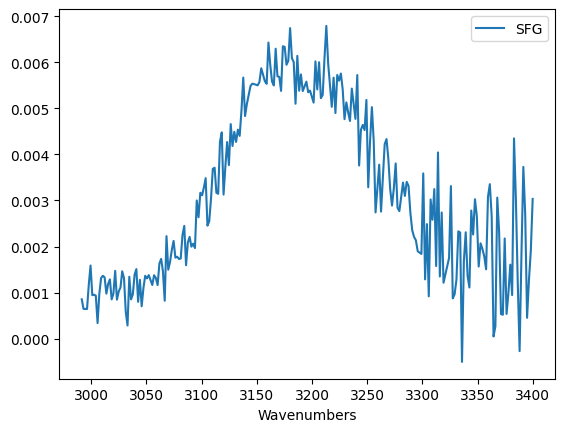

In [40]:
# @title Resize the window of the spectrum { display-mode: "form" }
WMin = 2990 # @param {type:"number"}
WMax  = 3400 # @param {type:"number"}
filtered_data = data.query(f'Wavenumbers > {WMin} and Wavenumbers < {WMax}')
# Plots the data with the new range
filtered_data.plot('Wavenumbers','SFG')
wavenumbers = filtered_data['Wavenumbers'].values
sfg = filtered_data['SFG'].values
calcamplitude = curry(wavenumbers,calcamplitude_of_wavenumbers)
calcimaginary = curry(wavenumbers,calcimaginary_of_wavenumbers)
costfunction = curry(sfg,costfunction_of_sfg)
costfunction.errordef = Minuit.LEAST_SQUARES

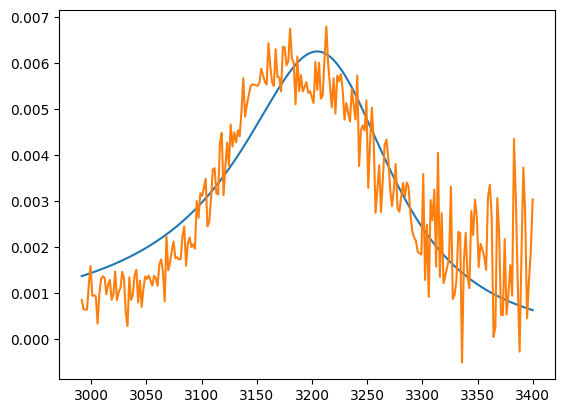

In [48]:
# @title Adjust the initial parameters to check the convergence of the fit { display-mode: "form" }
nonres_amplitude = 0.011 # @param {type:"number"}
nonres_phase  = 3.6# @param {type:"number"}
res_amplitude = 1.5 # @param {type:"number"}
res_pos = 3100 # @param {type:"number"}
res_width = 100 # @param {type:"number"}

nr = { "amplitude": nonres_amplitude,
       "phase": nonres_phase }
r0 = { "amplitude" : res_amplitude,
       "pos" : res_pos,
       "width" : res_width }
resonant_list = [r0]
parameters = combine_params( nr, resonant_list)

fit = Minuit(costfunction, name=parameters.keys(), *parameters.values())

# Ranges should only be positive
if 'nr_amplitude' in parameters:
  fit.limits["nr_amplitude"] = (0, None)
  fit.limits["nr_phase"] = (0, 2*np.pi)
for i in range((len(parameters)-2//3)):
  if 'r'+str(i)+'_amplitude' in parameters:
    fit.limits['r'+str(i)+'_amplitude'] = (0, None)
    fit.limits['r'+str(i)+'_pos'] = (WMin, WMax)
    fit.limits['r'+str(i)+'_width'] = (0, None)

fit.fixed["nr_amplitude"] = True
fit.fixed["nr_phase"] = True

# perform the fit
fit.migrad()

# plot result of fit with optimized parameters vs. experiment
plt.plot(filtered_data['Wavenumbers'],calcamplitude(fit.params[0].value,fit.params[1].value,fit.params[2].value,fit.params[3].value,fit.params[4].value))
plt.plot(filtered_data['Wavenumbers'],filtered_data['SFG'])

This step performs the actual optmization of the parameters (the results look cool, not sure what all these numbers mean...)

We can access the final value and associated error with the .value and .error attributes

In [49]:
print(fit.params[0].value,fit.params[1].value,fit.params[2].value,fit.params[3].value,fit.params[4].value)

0.011 3.6 6.225202267577316 3214.69964134196 170.51741533294205


Now we can reuse the calcamplitude function with the optimal parameters to compare to the experimental data

## Combine everything to fit six resonances

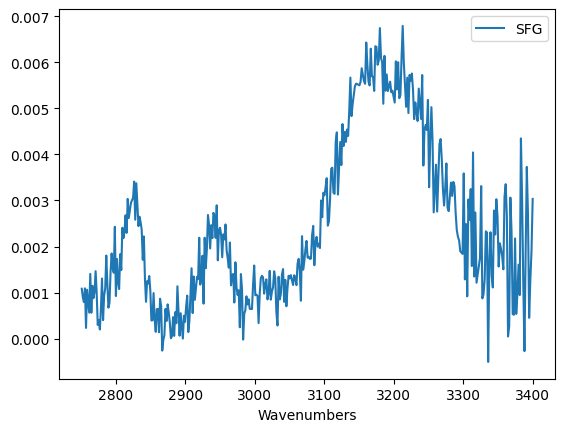

In [57]:
# @title Resize the window of the spectrum { display-mode: "form" }
WMin = 2750 # @param {type:"number"}
WMax  = 3400 # @param {type:"number"}
filtered_data = data.query(f'Wavenumbers > {WMin} and Wavenumbers < {WMax}').copy()
filtered_data.plot('Wavenumbers','SFG')
wavenumbers = filtered_data['Wavenumbers'].values
sfg = filtered_data['SFG'].values
calcamplitude = curry(wavenumbers,calcamplitude_of_wavenumbers)
calcimaginary = curry(wavenumbers,calcimaginary_of_wavenumbers)
costfunction = curry(sfg,costfunction_of_sfg)
costfunction.errordef = Minuit.LEAST_SQUARES

In [78]:
nr = { "amplitude": 0.011,
       "phase": 3.6 }
r0 = { "amplitude" : 0.8,
       "pos" : 2826,
       "width" : 30 }
r1 = { "amplitude" : 1,
       "pos" : 2943,
       "width" : 47 }
r2 = { "amplitude" : 5,
       "pos" : 3150,
       "width" : 170 }
r3 = { "amplitude" : 2,
       "pos" : 3214,
       "width" : 170 }


resonant_list = [r0, r1, r2, r3]
parameters = combine_params( nr, resonant_list)

fit = Minuit(costfunction, name=parameters.keys(), *parameters.values())

# Ranges should only be positive
if 'nr_amplitude' in parameters:
  fit.limits["nr_amplitude"] = (0, None)
  fit.limits["nr_phase"] = (0, 2*np.pi)
for i in range((len(parameters)-2//3)):
  if 'r'+str(i)+'_amplitude' in parameters:
    fit.limits['r'+str(i)+'_amplitude'] = (0, None)
    fit.limits['r'+str(i)+'_pos'] = (WMin, WMax)
    fit.limits['r'+str(i)+'_width'] = (0, None)

#fit.fixed["nr_amplitude"] = True
#fit.fixed["nr_phase"] = True

# perform the fit
fit.migrad()


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 0.0001598                  │              Nfcn = 282              │
│ EDM = 2.06e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│     SOME parameters at limit     │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │     Covariance FORCED pos. def.      │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name         │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ nr_amplitude │     0     │    15     │            │            │    0    │         │       │
│ 1 │ nr_phase     │    0.4    │    3.3    │            │            │    0    │ 6.28319 │       │
│ 2 │ r0_amplitude │     0     │    80     │            │            │    0    │         │       │
│ 3 │ r0_pos       │   2.8e3   │   0.5e3   │            │            │  2750   │  3400   │       │
│ 4 │ r0_width     │     0     │   2.7e3   │            │            │    0    │         │       │
│ 5 │ r1_amplitude │     0     │  0.17e3   │            │            │    0    │         │       │
│ 6 │ r1_pos       │   2.9e3   │   0.4e3   │            │            │  2750   │  3400   │       │
│ 7 │ r1_width     │    0e3    │    5e3    │            │            │    0    │         │       │
│ 8 │ r2_amplitude │  0.01e3   │  0.27e3   │            │            │    0    │         │       │
│ 9 │ r2_pos       │   3.1e3   │   0.5e3   │            │            │  2750   │  3400   │       │
│ 10│ r2_width     │    0e3    │    6e3    │            │            │    0    │         │       │
│ 11│ r3_amplitude │     0     │   0.4e3   │            │            │    0    │         │       │
│ 12│ r3_pos       │  3.21e3   │  0.33e3   │            │            │  2750   │  3400   │       │
│ 13│ r3_width     │     0     │  0.017e6  │            │            │    0    │         │       │
└───┴──────────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────────┬───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│              │ nr_amplitude     nr_phase r0_amplitude       r0_pos     r0_width r1_amplitude       r1_pos     r1_width r2_amplitude       r2_pos     r2_width r3_amplitude       r3_pos     r3_width │
├──────────────┼───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│ nr_amplitude │         5.14      1.450e3           77      4.910e3     -1.704e3          256      5.391e3      1.232e3          450     -6.650e3     -4.741e3          602    -16.422e3     -8.332e3 │
│     nr_phase │      1.450e3     5.54e+05         23e3        2.0e6       -0.7e6      0.089e6        2.3e6        0.4e6       0.17e6       -1.7e6       -1.8e6       0.24e6       -5.0e6       -3.0e6 │
│ r0_amplitude │           77         23e3     4.41e+03         69e3         89e3          3e3         85e3        -19e3          7e3       -106e3        -92e3          9e3       -259e3       -169e3 │
│       r0_pos │      4.910e3        2.0e6         69e3     1.03e+07         -3e6      0.326e6      

In [79]:
optimized_parameters = dict(zip(parameters.keys(),[p.value for p in fit.params]))

In [80]:
optimized_parameters.values()

dict_values([0.010338265553632845, 0.4377836382276159, 0.7960422816495131, 2827.6481266872233, 30.40919086710215, 0.9988279945006633, 2945.0664060629847, 47.48130445643001, 5.049452045750234, 3149.4228897233907, 166.5916943624069, 2.0297272246174862, 3207.5564414234836, 168.7973833577842])

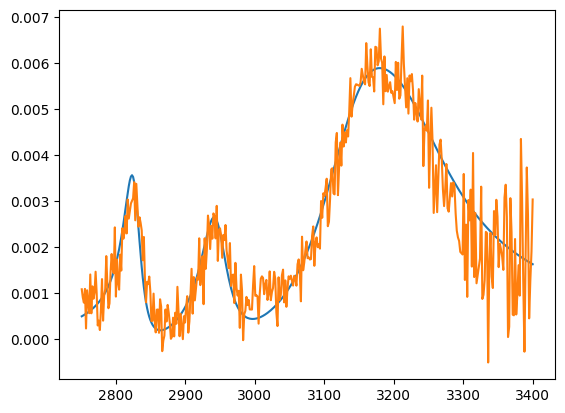

In [81]:
plt.plot(filtered_data['Wavenumbers'],calcamplitude(*optimized_parameters.values()))
plt.plot(filtered_data['Wavenumbers'],filtered_data['SFG'])

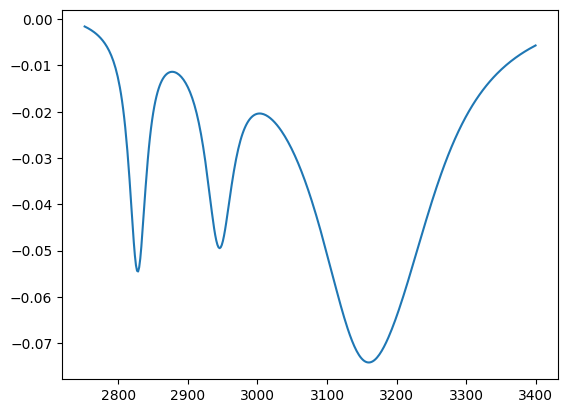

In [82]:
plt.plot(filtered_data['Wavenumbers'],calcimaginary(*optimized_parameters.values()))